# Task 1: Word Embeddings (10 points)

This notebook will guide you through all steps necessary to train a word2vec model (Detailed description in the PDF).

## Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages)

In [1]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
print("Done")

Done


# 1.1 Get the data (0.5 points)

The Hindi portion HASOC corpus from [github.io](https://hasocfire.github.io/hasoc/2019/dataset.html) is already available in the repo, at data/hindi_hatespeech.tsv . Load it into a data structure of your choice. Then, split off a small part of the corpus as a development set (~100 data points).

If you are using Colab the first two lines will let you upload folders or files from your local file system.

In [2]:

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
    
bengali_data = pd.read_csv('data/bengali_hatespeech.csv')

bengali_data_hate = bengali_data.loc[bengali_data['hate'] == 1]
bengali_data_not_hate = bengali_data.loc[bengali_data['hate'] == 0]

bengali_data_hate = bengali_data_hate.iloc[0:2332] 
bengali_data_not_hate = bengali_data_not_hate.iloc[0:2333]

data_development = pd.concat([bengali_data_hate, bengali_data_not_hate])
data_development = shuffle(data_development)
data_development.columns = ["text", "hate", "category"]

labels = data_development['hate']
labels = np.array(labels)
print(data_development)

                                                    text  hate       category
1106   জার্সি পরা মাগীর ছেলেকে ঘন্টা পিটানো হক সাকিব ...     1         sports
1904   মোমো এবং ফারিয়া দুইটাই উন্নত মানের দুধেল গাভী ...     1  entertainment
11066  এইভাবে ছেলেটাকে হেনস্থা করা ঠিক না।যারা ওকে ধর...     0         sports
577         পাপন একটা খানকির ছেলে অর পদত্যাগ চাই চাই চাই     1         sports
2322                                                 বাল     1  entertainment
...                                                  ...   ...            ...
729                        তুই মারাজাছ না কেন মাগীর পুলা     1         sports
1348             আওয়ামী লীগের সালারা সব পারে এটাই প্রমান     1         sports
10704  মহানবি হযরত মুহাম্মদ সাঃ এর ভক্ত আছো কে কে সাড...     0         sports
11680  রুবেল সৈই চালাক । মেয়েটি লোভী ছিল । উল্টা ঠকছে...     0         sports
63     রফিক আমার চেটের বাল🐸মুশি রিয়াদ টাকা দে তাই হেত...     1         sports

[4665 rows x 3 columns]


## 1.2 Data preparation (0.5 + 0.5 points)

* Prepare the data by removing everything that does not contain information. 
User names (starting with '@') and punctuation symbols clearly do not convey information, but we also want to get rid of so-called [stopwords](https://en.wikipedia.org/wiki/Stop_word), i. e. words that have little to no semantic content (and, but, yes, the...). Hindi stopwords can be found [here](https://github.com/stopwords-iso/stopwords-hi/blob/master/stopwords-hi.txt) Then, standardize the spelling by lowercasing all words.
Do this for the development section of the corpus for now.

* What about hashtags (starting with '#') and emojis? Should they be removed too? Justify your answer in the report, and explain how you accounted for this in your implementation.

In [4]:
#TODO: implement!
# file = '/content/drive/My Drive/stopwords-hi.txt'

# with open(file, 'r', encoding="utf8") as f2:
#     hindi_stopword_file = f2.read()
    
    
hindi_stopword_file = open('data/stopwords-hi.txt', encoding="utf8")

sw_list = ['#', '?', '!', ';', ',', ':', "\'", '-', '=', '(', ')', '[', ']' , '{', '}', '"', '*', '@', '  ', '\\', '/', '..', '...', '....', '%'
          ,'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\t']
sw_list_string = ''
for i in sw_list:
    sw_list_string+=i
hindi_stopwords = []
for x in hindi_stopword_file:
    hindi_stopwords.append(x.rstrip())

hindi_stopwords.extend(sw_list)
sentences = []
for text in data_development['text']:
    text_array = text.split(' ')
    new_array = []
    for j in text_array:
        if '@' not in j and len(j) < 20:
            for char in sw_list:
                j = j.replace(char, '')
            new_array.append(j.lower())
    sentences.append(' '.join(new_array))

print("Done", len(sentences))

Done 4665


## 1.3 Build the vocabulary (0.5 + 0.5 points)

The input to the first layer of word2vec is an one-hot encoding of the current word. The output od the model is then compared to a numeric class label of the words within the size of the skip-gram window. Now

* Compile a list of all words in the development section of your corpus and save it in a variable ```V```.

In [5]:
#TODO: implement!
temp_unique = [] # For unique words
temp_nounique = []
for j in sentences:
    temp2 = j.split(' ')
    for k in temp2:
        if k not in temp_unique:
            temp_unique.append(k)
        temp_nounique.append(k)
V = temp_unique
non_unique = temp_nounique
print('Total words:', len(non_unique))
print('Unique words:', len(V))

Total words: 64027
Unique words: 14482


* Then, write a function ```word_to_one_hot``` that returns a one-hot encoding of an arbitrary word in the vocabulary. The size of the one-hot encoding should be ```len(v)```.

In [6]:
#TODO: implement!
def word_to_one_hot(word, features):
    if word in V:
        index = V.index(word)
        encoding = np.zeros(features)
        encoding[index]= 1
        return encoding.astype(np.uint8)
    return False

def not_word_to_one_hot(word, features):
    if word in V:
        index = V.index(word)
#         encoding = np.zeros(features)
#         encoding[index]= 1
        return index
    return False
#   pass

def index_to_onehot(X_batch):
    X_batch_new = []
    y_batch_new = []
    encodingX = np.eye(4)[X_batch]
    return type(encodingX)

## 1.4 Subsampling (0.5 points)

The probability to keep a word in a context is given by:

$P_{keep}(w_i) = \Big(\sqrt{\frac{z(w_i)}{0.001}}+1\Big) \cdot \frac{0.001}{z(w_i)}$

Where $z(w_i)$ is the relative frequency of the word $w_i$ in the corpus. Now,
* Calculate word frequencies
* Define a function ```sampling_prob``` that takes a word (string) as input and returns the probabiliy to **keep** the word in a context.

In [7]:
#TODO: implement!
def sampling_prob(word):
    z_wi = non_unique.count(word) / len(non_unique)
    try:
        p_wi = (mt.sqrt(z_wi / 0.001) + 1) * (0.001 / z_wi)
        return p_wi
    except ZeroDivisionError:
        print("Word doesn't exist in corpus")
    pass

# 1.5 Skip-Grams (1 point)

Now that you have the vocabulary and one-hot encodings at hand, you can start to do the actual work. The skip gram model requires training data of the shape ```(current_word, context)```, with ```context``` being the words before and/or after ```current_word``` within ```window_size```. 

* Have closer look on the original paper. If you feel to understand how skip-gram works, implement a function ```get_target_context``` that takes a sentence as input and [yield](https://docs.python.org/3.9/reference/simple_stmts.html#the-yield-statement)s a ```(current_word, context)```.

* Use your ```sampling_prob``` function to drop words from contexts as you sample them. 

In [9]:
#TODO: implement!
def get_target_context(sentence, window_size):
    word = ''
    words_in_sentence = sentence.split(' ')
    for i in range(len(words_in_sentence)):
        context = []
        randd = random.random()
#         print('1st: ', words_in_sentence[i], sampling_prob(words_in_sentence[i]), randd)
        if randd <= sampling_prob(words_in_sentence[i]):
            word = words_in_sentence[i]
            upper_bound = i + window_size + 1
            lower_bound = i - window_size
            for j in range(lower_bound, upper_bound):
                rand2 = random.random()
                if i != j and j>=0 and j<len(words_in_sentence):
                    if rand2 <= sampling_prob(words_in_sentence[j]):
#                     print('2nd: ', words_in_sentence[i], words_in_sentence[j],sampling_prob(words_in_sentence[j]), rand2)
                        context.append(words_in_sentence[j])
        if len(word) > 0 and len(context) > 0:
            yield(word, context)
            
hello = get_target_context(sentences[22], 4)

print("Done")

Done


# 1.6 Hyperparameters (0.5 points)

According to the word2vec paper, what would be a good choice for the following hyperparameters? 

* Embedding dimension
* Window size

Initialize them in a dictionary or as independent variables in the code block below. 

In [10]:
# Set hyperparameters
# window_size = from 1 to 10
# window_size = from 500 to 1000 (640 used in paper)
window_size = 4
embedding_size = 600

# More hyperparameters
learning_rate = 0.05
epochs =100

# 1.7 Pytorch Module (0.5 + 0.5 + 0.5 points)

Pytorch provides a wrapper for your fancy and super-complex models: [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The code block below contains a skeleton for such a wrapper. Now,

* Initialize the two weight matrices of word2vec as fields of the class.

* Override the ```forward``` method of this class. It should take a one-hot encoding as input, perform the matrix multiplications, and finally apply a log softmax on the output layer.

* Initialize the model and save its weights in a variable. The Pytorch documentation will tell you how to do that.

In [11]:
# Create model 

class Word2Vec(nn.Module):
    def __init__(self, features, embedding_size):
        super().__init__()
        self.fc1 = nn.Linear(features, embedding_size)
        self.fc2 = nn.Linear(embedding_size, features)


    def forward(self, one_hot):
        x = self.fc1(one_hot.float())
        x = self.fc2(x)
        log_softmax = torch.nn.functional.log_softmax(x, dim=1)
        return log_softmax
#     pass

print("Done")

Done


# 1.8 Loss function and optimizer (0.5 points)

Initialize variables with [optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and loss function. You can take what is used in the word2vec paper, but you can use alternative optimizers/loss functions if you explain your choice in the report.

### Creating target, context tuple

In [13]:
def create_dataset(sentences):
    x_train = []
    y_train = []
    count = 0
    print("started")
    for j, i in enumerate(sentences):
        if (j + 1) % 50 == 0:
            print("INDEX:", j, "Length:",len(x_train))
        word_context = get_target_context(i, random.randint(1,10))
        for word, context in word_context:
            input_vec = not_word_to_one_hot(word, len(V))
            for j in context:
                output_vec = not_word_to_one_hot(j, len(V))
                x_train.append(input_vec)
                y_train.append(output_vec)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    np.save('x_train_bengali', x_train)
    np.save('y_train_bengali', y_train)
    return x_train, y_train
print(len(sentences))
x_train, y_train = create_dataset(sentences)
print(x_train.shape)

4665
started
INDEX: 49 Length: 3964
INDEX: 99 Length: 8219
INDEX: 149 Length: 13079
INDEX: 199 Length: 19076
INDEX: 249 Length: 22783
INDEX: 299 Length: 27994
INDEX: 349 Length: 33054
INDEX: 399 Length: 38911
INDEX: 449 Length: 43817
INDEX: 499 Length: 48700
INDEX: 549 Length: 53380
INDEX: 599 Length: 58307
INDEX: 649 Length: 61126
INDEX: 699 Length: 66529
INDEX: 749 Length: 72041
INDEX: 799 Length: 77451
INDEX: 849 Length: 81580
INDEX: 899 Length: 87969
INDEX: 949 Length: 94249
INDEX: 999 Length: 98067
INDEX: 1049 Length: 104398
INDEX: 1099 Length: 108887
INDEX: 1149 Length: 112096
INDEX: 1199 Length: 119305
INDEX: 1249 Length: 122001
INDEX: 1299 Length: 126109
INDEX: 1349 Length: 132447
INDEX: 1399 Length: 136978
INDEX: 1449 Length: 140960
INDEX: 1499 Length: 145652
INDEX: 1549 Length: 150723
INDEX: 1599 Length: 154219
INDEX: 1649 Length: 160630
INDEX: 1699 Length: 166198
INDEX: 1749 Length: 171669
INDEX: 1799 Length: 175663
INDEX: 1849 Length: 179497
INDEX: 1899 Length: 183058
INDEX

### Loading to dataloader

In [14]:
print(y_train[0])
batch_size = 1000
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_train = data_utils.TensorDataset(x_train, y_train)
train_dl = DataLoader(x_train, batch_size=batch_size, shuffle=True)
# del x_train
# print(len(V))
features = len(V)
total_rows = len(y_train)
print(total_rows)
# del y_train

1
448854


# 1.9 Training the model (3 points)

As everything is prepared, implement a training loop that performs several passes of the data set through the model. You are free to do this as you please, but your code should:

* Load the weights saved in 1.6 at the start of every execution of the code block
* Print the accumulated loss at least after every epoch (the accumulate loss should be reset after every epoch)
* Define a criterion for the training procedure to terminate if a certain loss value is reached. You can find the threshold by observing the loss for the development set.

You can play around with the number of epochs and the learning rate.

Started:


<ipython-input-15-d75c1c675acc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(y_pred_torch, torch.max(torch.tensor(y_batch), 1)[1])


Epoch: 0 	Loss: 8.06457371701111
Epoch: 1 	Loss: 7.097379783214068
Epoch: 2 	Loss: 6.841117040086164
Epoch: 3 	Loss: 6.7123113698046035
Epoch: 4 	Loss: 6.622108471154635
Epoch: 5 	Loss: 6.556159672599062
Epoch: 6 	Loss: 6.503734928462447
Epoch: 7 	Loss: 6.467378518629181
Epoch: 8 	Loss: 6.440557552074271
Epoch: 9 	Loss: 6.416795361015473
Epoch: 10 	Loss: 6.393877284298496
Epoch: 11 	Loss: 6.370895241310443
Epoch: 12 	Loss: 6.349754609615606
Epoch: 13 	Loss: 6.336859772093843
Epoch: 14 	Loss: 6.32120620753027
Epoch: 15 	Loss: 6.302735242652468
Epoch: 16 	Loss: 6.292469624687143
Epoch: 17 	Loss: 6.281074477197864
Epoch: 18 	Loss: 6.26736055663009
Epoch: 19 	Loss: 6.256652884069158
Epoch: 20 	Loss: 6.2483494255218845
Epoch: 21 	Loss: 6.240326163497959
Epoch: 22 	Loss: 6.229096388232734
Epoch: 23 	Loss: 6.219747252347474
Epoch: 24 	Loss: 6.211229831975924
Epoch: 25 	Loss: 6.207000768529811
Epoch: 26 	Loss: 6.201535836625471
Epoch: 27 	Loss: 6.194525578505212
Epoch: 28 	Loss: 6.186886371111

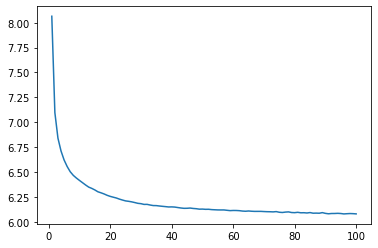

In [15]:
# Define optimizer and loss

net = Word2Vec(len(V), embedding_size)
# net.load_state_dict(torch.load('model_param'))
net.to(dev)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.NLLLoss()

def train():
    print("Started:")
    loss_vals=  []
    for e in range(epochs):
        epoch_loss= []
        for i, (X_batch, y_batch) in enumerate(train_dl):
            X_batch = np.eye(len(V))[X_batch]
            y_batch = np.eye(len(V))[y_batch]
            X_batch = torch.Tensor(X_batch).to(dev)
            y_batch = torch.Tensor(y_batch).to(dev)
            y_pred_torch = net(X_batch)
            loss = criterion(y_pred_torch, torch.max(torch.tensor(y_batch), 1)[1])
            optimizer.zero_grad()
            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print('Epoch:', e,'\tLoss:',loss_vals[e])
#         break
    plt.plot(np.linspace(1, 100, 100).astype(int), loss_vals)
    plt.savefig('Task1_benali.png') 
train()

print("Training finished")

In [16]:
print(y_train.shape)

torch.Size([448854])


# 1.10 Train on the full dataset (0.5 points)

Now, go back to 1.1 and remove the restriction on the number of sentences in your corpus. Then, reexecute code blocks 1.2, 1.3 and 1.6 (or those relevant if you created additional ones). 

* Then, retrain your model on the complete dataset.

* Now, the input weights of the model contain the desired word embeddings! Save them together with the corresponding vocabulary items (Pytorch provides a nice [functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for this).

###### 